# Distillery Exploration, Clustering and Recommendations

In [162]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import folium
from shapely.geometry import Point
from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.impute import SimpleImputer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


# hierarchical clustering with geographical consraints
# link individual reviewers to distilleries, based on their demonstrated flavor preferences - CLUSTGEO R project - paper published in 2018 - 

Data cleaning 

In [125]:
### I have manually corrected spelling issues and spaces in the names from the original dataset - verified with the postcode
# 86 distillery data + Reddit Data + MetaCritic Data
distil = pd.read_csv('86 distil.txt')
distil['Postcode'] = distil['Postcode'].str.lstrip('\t ')
distil.columns = distil.columns.str.strip()
# stripping postcodes to generalise areas
distil['Postcode'] = distil['Postcode'].str[:2]
for index, row in distil.iterrows():
    if row['Postcode'].startswith('G'):
        distil.at[index, 'Postcode'] = 'G'
Y = distil['Distillery']
distil.drop('RowID', axis=1, inplace = True)

reddit = pd.read_csv('Reddit.csv')
critic = pd.read_csv('MetaCritic.csv')

# Extracting only bottles from our distillery list
# reddit 
names = Y.tolist()
search_pattern = '|'.join(names)
reddit['Distillery'] = reddit['Whisky Name'].str.extract(f'(?i)({search_pattern})', expand=False).str.lower()
reddit = reddit[pd.notna(reddit['Distillery'])]
distillery_count_reddit = reddit['Distillery'].value_counts()


# Renaming columns
reddit = reddit[['Whisky Name', "Reviewer's Reddit Username", 'Link To Reddit Review', 'Reviewer Rating', 'Whisky Region or Style', 'Distillery']].rename(columns={
    'Whisky Name': 'Bottle',
    "Reviewer's Reddit Username": 'Username',
    'Reviewer Rating': 'Rating',
    'Whisky Region or Style': 'Region',
    'Distillery': 'Distillery', 'Link To Reddit Review': 'Link'
})
# deleting anything without a rating value reddit = reddit[pd.to_numeric(reddit['Rating'], errors='coerce').notna()]
reddit = reddit[pd.to_numeric(reddit['Rating'], errors='coerce').notna()]
# only saving users that have had 5 or more reviews
username_count_reddit = reddit['Username'].value_counts()


# Filtering Critic data for Scotland only (our 86 distils) and relevant columns
critic = critic[critic['Country'] == 'Scotland']
critic['Distillery'] = critic['Whisky'].str.extract(f'(?i)({search_pattern})', expand=False)
critic = critic[pd.notna(critic['Distillery'])]
distillery_count_meta = critic['Distillery'].value_counts()
# for critic - i want, whisky = bottle name, Meta Critic = Rating, STDEV, Super Cluster, Cluster, Distillery
critic = critic[['Whisky', 'Meta Critic', '#', 'STDEV','Super Cluster', 'Cluster','Distillery']].rename(columns={'Whisky':'Bottle', 'Meta Critic':'Rating', '#':'Number of Reviews'})

# stripping postcodes to generalise areas



In [126]:
distil

,Distillery,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral,Postcode,Latitude,Longitude
0,Aberfeldy,2,2,2,0,0,2,1,2,2,2,2,2,PH,286580,749680
1,Aberlour,3,3,1,0,0,4,3,2,2,3,3,2,AB,326340,842570
2,AnCnoc,1,3,2,0,0,2,0,0,2,2,3,2,AB,352960,839320
3,Ardbeg,4,1,4,4,0,0,2,0,1,2,1,0,PA,141560,646220
4,Ardmore,2,2,2,0,0,1,1,1,2,3,1,1,AB,355350,829140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,Tobermory,1,1,1,0,0,1,0,0,1,2,2,2,PA,150450,755070
82,Tomatin,2,3,2,0,0,2,2,1,1,2,0,1,IV,279120,829630
83,Tomintoul,0,3,1,0,0,2,2,1,1,2,1,2,AB,315100,825560
84,Tormore,2,2,1,0,0,1,0,1,2,1,0,0,PH,315180,834960


In [127]:
distillery_count_meta = critic['Super Cluster'].value_counts()
distillery_count_meta
# not going to use these as it just complicates things, the 86 distl is more granular.

Super Cluster
ABC    257
EF     162
GH     108
I       94
J       84
Name: count, dtype: int64

In [128]:
sum = 0
for username, count in username_count_reddit.items():
    if count > 10:
        sum += 1
sum
# we have 74 users who have left over 50 reviews, 96 over 40, 113 over 30, 148 over 20, 278 over 10.

278

# Geo-Location Coordinates - via OpenMaps

Plot locations of the 86 distilleries to get an idea of how many clusters, their shape, size etc. to know which algo to (not) use

In [129]:
geolocator = Nominatim(user_agent="distil_plotter")
# added in missing distilleries to openstreetmap manually 
def geocode_distillery(row):
    location = geolocator.geocode(f"{row['Distillery']} Distillery")
    # hasnt actually improved the search but maybe one day lol
    locationb = geolocator.geocode(f"{row['Distillery']}")
    if location:
        return Point(location.longitude, location.latitude)
    elif locationb:
        return Point(locationb.longitude, locationb.latitude)
    # special case for glen deveron macduff distillery, as the bottles are labelled glen deveron, but the distillery is macduff
    elif row['Distillery'] == 'Glen Deveron Macduff':
        loc_macduff = geolocator.geocode('Macduff Distillery')
        return Point(loc_macduff.longitude, loc_macduff.latitude)
    else:
        return None

distil['geometry'] = distil.apply(geocode_distillery, axis=1)


In [130]:
# Geocode the coordinates of Scotland
location = geolocator.geocode("Scotland")

# Create a folium map centered around Scotland
map_scotland = folium.Map(location=[location.latitude, location.longitude], zoom_start=6)

# Add markers for distil_gdf points to the Folium map
for idx, distil_point in distil.iterrows():
    if distil_point['geometry']:
        latitude, longitude = distil_point['geometry'].y, distil_point['geometry'].x  # Corrected access to coordinates
        folium.CircleMarker(
            location=[latitude, longitude],
            radius=3,  # Adjust the radius as needed
            color='red',
            fill=True,
            fill_color='pink',
            popup=distil_point['Distillery']
        ).add_to(map_scotland)

# Show the Folium map
display(map_scotland)
map_scotland.save("map_scotland.html")

In [131]:
missing_values = distil[['geometry', 'Distillery']].isnull().sum()
print(missing_values)


geometry      0
Distillery    0
dtype: int64


In [132]:
# spelling errors/missing spaces etc. corrected manually: AnCnoc=website name/distillery is different so im not changing it, ArranIsleOf=Arran Craigallechie=distil name is owners so not changing Craigganmore=Cragganmore GlenDeveronMacduff = either known as Glex Deveron, or Macduff, using spaces  GlenGarioch = glen garioch GlenScotia = Glen Scotia Knochando = Knockando  Laphroig = Laphroaig OldFettercairn = Fettercairn OldPulteney=Old Pulteney RoyalBrackla=Royal Brackla RoyalLochnagar =Royal Lochnagar
for idx, row in distil.iterrows():
    if row['geometry']==None:
        print(row['Distillery'])

In [133]:
def update_frompoint(row):
    if row['geometry']:
        latitude, longitude = row['geometry'].y, row['geometry'].x
        row['Latitude'] = latitude
        row['Longitude'] = longitude
    else:
        # no longer required as I've added missing locations to openstreet
        row['Latitude'] = 'missing'
        row['Longitude'] = 'missing'
    return row

distil = distil.apply(update_frompoint, axis=1)

In [134]:
distil_with_clusters = distil.copy()

Flavor Profile Heat Map

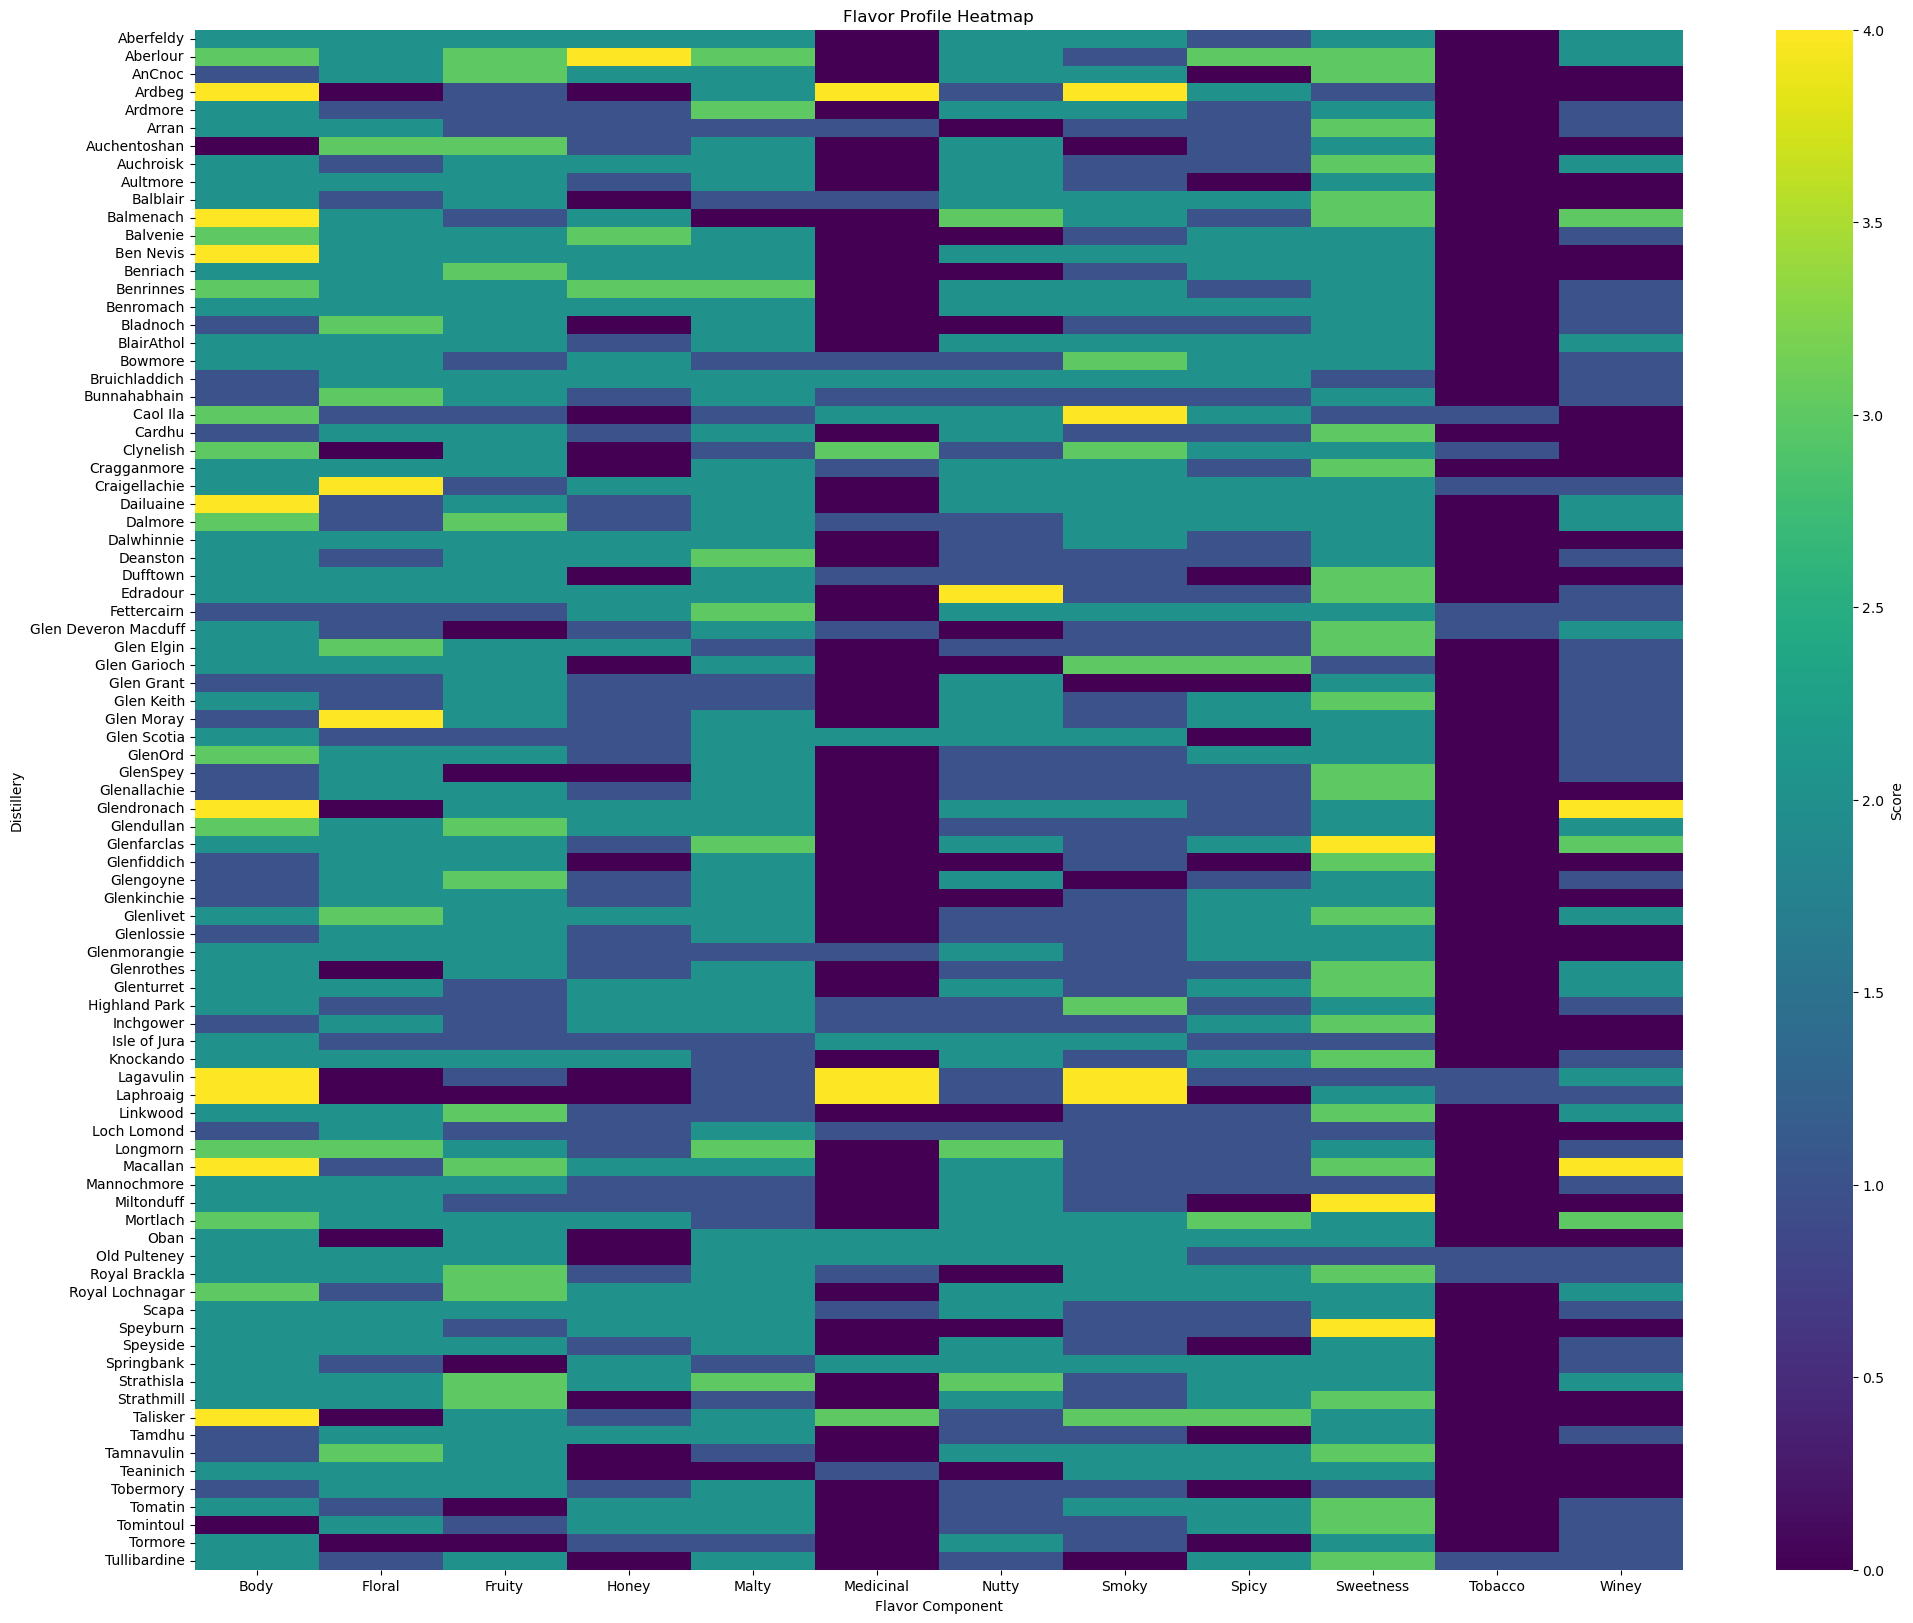

In [135]:
# Swap axes to long format
distil_long = distil.melt(id_vars=['Distillery'], value_vars=['Body', 'Sweetness', 'Smoky', 'Medicinal', 'Tobacco', 'Honey', 'Spicy', 'Winey', 'Nutty', 'Malty', 'Fruity', 'Floral'])


plt.figure(figsize=(24, 20))
heatmap_data = distil_long.pivot_table(index='Distillery', columns='variable', values='value', aggfunc='mean')
sns.heatmap(heatmap_data, cmap='viridis', cbar_kws={'label': 'Score'})

plt.xlabel('Flavor Component')
plt.ylabel('Distillery')
plt.title('Flavor Profile Heatmap')
plt.savefig('FlavourHeatmap.png')
plt.show()

MetaCritic dataset - not used beyond top 3 highest ratings in the end, but keeping for future use

In [136]:
critic

,Bottle,Rating,Number of Reviews,STDEV,Super Cluster,Cluster,Distillery
0,"Macallan 10yo Full Proof 57% 1980 (OB, Giovine...",9.58,3,0.25,ABC,A,Macallan
2,"Laphroaig 27yo 57.4% 1980-2007 (OB, 5 Oloroso ...",9.42,4,0.24,ABC,C,Laphroaig
3,Glenfarclas 40yo,9.29,17,0.26,ABC,A,Glenfarclas
5,Glengoyne 25yo,9.20,22,0.28,ABC,A,Glengoyne
6,Highland Park 25yo,9.18,19,0.18,ABC,C,Highland Park
...,...,...,...,...,...,...,...
1199,Benromach Peat Smoke,8.54,21,0.33,J,J,Benromach
1200,Bruichladdich Port Charlotte The Peat Project,8.51,7,0.38,J,J,Bruichladdich
1205,Bunnahabhain Cruach Mhona,8.38,9,0.40,J,J,Bunnahabhain
1206,Laphroaig QA Cask,8.23,12,0.55,J,J,Laphroaig


In [137]:
# Group by Distillery and calculate the mean and standard deviation of the Rating
weighted_mean_per_distillery = critic.groupby('Distillery').apply(lambda group: (group['Rating'] * group['Number of Reviews']).sum() / group['Number of Reviews'].sum()).reset_index()

# Rename the columns for clarity
weighted_mean_per_distillery.columns = ['Distillery', 'Weighted_Mean_Rating']

# Print or display the result
weighted_mean_per_distillery.sort_values(by='Weighted_Mean_Rating', ascending=True)
## this is the only data im keeping from the critic dataset - the cluster data is based on his own analysis, and my features are more comprehensive. stdev can be ignored as we are combining and its a tiny data point, might include later to account for large variations
weighted_mean_per_distillery.set_index('Distillery', inplace=True)
weighted_mean_per_distillery

,Weighted_Mean_Rating
Distillery,
Aberfeldy,8.361915
Aberlour,8.786372
AnCnoc,8.682314
Ardbeg,8.937008
Ardmore,8.480000
...,...
Tobermory,8.404615
Tomatin,8.401591
Tomintoul,8.100000


In [138]:
top_3 = weighted_mean_per_distillery.sort_values(by='Weighted_Mean_Rating', ascending=False).head(3)

In [139]:
weighted_mean_per_distillery.index = weighted_mean_per_distillery.index.str.lower()

In [140]:
# Count the number of rows for each distillery
distillery_counts = critic['Distillery'].value_counts().reset_index()

# Rename the columns for clarity
distillery_counts.columns = ['Distillery', 'Count']

# Filter distilleries with counts greater than 3
distilleries_greater_than_3 = distillery_counts[distillery_counts['Count'] > 2]

# Print or display the result
print(distilleries_greater_than_3)

       Distillery  Count
0   Bruichladdich     70
1        Aberlour     40
2        Macallan     32
3   Highland Park     30
4        BenRiach     24
5     GlenDronach     24
6           Arran     23
7     Glenfiddich     23
8       Laphroaig     22
9          Ardbeg     21
10        Bowmore     20
11   Glenmorangie     19
12     Glenrothes     18
13      Glengoyne     17
14   Bunnahabhain     15
15      Glenlivet     14
16        Tomatin     14
17   Glen Garioch     14
18       Talisker     14
19     Springbank     12
20       Balvenie     12
21         AnCnoc     10
22   Auchentoshan     10
23       Bladnoch      9
24       Caol Ila      9
25   Tullibardine      9
26    Glenfarclas      9
27     Glen Moray      9
28        Dalmore      9
29   Old Pulteney      8
30     Glen Grant      8
31    Glen Scotia      8
32      Benromach      8
33       Balblair      8
34       Mortlach      7
35           Oban      6
36       Dufftown      6
37      Ben Nevis      6
38      Lagavulin      6


# Reddit Dataset

In [141]:
# only saving those with ratings - anything that ends up as NA hasn't had a rating transfer over, likely due no rating provided, or rating not provided in the right format by the user, which doesn't affect this too much
reddit['Rating'] = pd.to_numeric(reddit['Rating'], errors='coerce')
reddit = reddit[reddit['Rating'].notna()]
user_distillery_ratings = reddit.pivot_table(index='Username', columns='Distillery', values='Rating')

# Remove users that have only reviewed 1 distillery
user_distillery_ratings = user_distillery_ratings.loc[user_distillery_ratings.count(axis=1) > 1]
# removing the bias from individual user scales, ie, centering - how much each user's ratings deviate from their average rating 
normalized_ratings = user_distillery_ratings.sub(user_distillery_ratings.mean(axis=1), axis=0)
# we have 864 users for 81 distilleries


In [142]:
normalized_ratings

Distillery,aberfeldy,aberlour,ancnoc,ardbeg,ardmore,arran,auchentoshan,auchroisk,aultmore,balblair,...,strathmill,talisker,tamdhu,tamnavulin,teaninich,tobermory,tomatin,tomintoul,tormore,tullibardine
Username,,,,,,,,,,,,,,,,,,,,,
/r/scotch,NaN,0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12side,NaN,NaN,NaN,-1.250000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7.678571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1cenined,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1up_0,NaN,NaN,NaN,NaN,NaN,0.400000,NaN,-6.600000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2ply,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xreekinghavocx,1.652680,-3.247320,NaN,0.777680,-1.347320,0.652680,-0.347320,-2.513987,-0.513987,1.402680,...,-0.84732,-1.097320,-1.247320,-6.84732,7.152680,-3.180654,NaN,4.65268,NaN,NaN
yngwin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zSolaris,3.079498,2.246165,NaN,3.936641,-0.170502,4.079498,-6.920502,9.079498,2.079498,0.412832,...,NaN,5.793784,-3.920502,NaN,2.079498,5.079498,1.579498,NaN,1.079498,NaN


# Distillery Similarity Metric based on user preference (rating comparison)

In [143]:
# not using cosine - imputing 0s or anything else causes bias and cosine cant handle NAs - see spearman below
'''
# similarities between distilleries
#normalized_ratings = normalized_ratings.fillna(0)

# Transpose the user_ratings DataFrame to have distilleries as rows and users as columns
distillery_ratings = normalized_ratings.T

# Calculate cosine similarity between distilleries
distillery_similarity = cosine_similarity(distillery_ratings)
distillery_sim_pref = pd.DataFrame(distillery_similarity, index=normalized_ratings.columns, columns=normalized_ratings.columns)
print(distillery_sim_pref)

###### or the other way - similarities between users

# Calculate cosine similarity
cosine_sim = cosine_similarity(normalized_ratings)

cosine_sim_df = pd.DataFrame(cosine_sim, index=normalized_ratings.index, columns=normalized_ratings.index)
'''

'\n# similarities between distilleries\n#normalized_ratings = normalized_ratings.fillna(0)\n\n# Transpose the user_ratings DataFrame to have distilleries as rows and users as columns\ndistillery_ratings = normalized_ratings.T\n\n# Calculate cosine similarity between distilleries\ndistillery_similarity = cosine_similarity(distillery_ratings)\ndistillery_sim_pref = pd.DataFrame(distillery_similarity, index=normalized_ratings.columns, columns=normalized_ratings.columns)\nprint(distillery_sim_pref)\n\n###### or the other way - similarities between users\n\n# Calculate cosine similarity\ncosine_sim = cosine_similarity(normalized_ratings)\n\ncosine_sim_df = pd.DataFrame(cosine_sim, index=normalized_ratings.index, columns=normalized_ratings.index)\n'

In [144]:
pearson_corr = normalized_ratings.corr()
spearman_corr = normalized_ratings.corr(method='spearman')

distillery_sim_pref = pd.DataFrame(spearman_corr, index=normalized_ratings.columns, columns=normalized_ratings.columns)
print(distillery_sim_pref)

Distillery    aberfeldy  aberlour    ancnoc    ardbeg   ardmore     arran  \
Distillery                                                                  
aberfeldy      1.000000 -0.326266 -0.333846 -0.399577 -0.199605  0.030582   
aberlour      -0.326266  1.000000  0.125386  0.126148 -0.239642 -0.177811   
ancnoc        -0.333846  0.125386  1.000000 -0.031892 -0.097186 -0.164490   
ardbeg        -0.399577  0.126148 -0.031892  1.000000 -0.238129  0.046102   
ardmore       -0.199605 -0.239642 -0.097186 -0.238129  1.000000 -0.091327   
...                 ...       ...       ...       ...       ...       ...   
tobermory     -0.024597  0.011214 -0.212403  0.196969  0.005138  0.013875   
tomatin        0.005419 -0.263965 -0.013240 -0.234173  0.417261  0.012963   
tomintoul     -0.050649 -0.025276 -0.057391 -0.138649  0.106227  0.066924   
tormore        0.285294 -0.264822  0.046617 -0.112308 -0.025564  0.097680   
tullibardine   0.093137 -0.107389 -0.536985 -0.186163 -0.122609  0.087395   

# Location Data - Distance Calculation


In [145]:
# Distance on earth
def haversine_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    radius = 6371.0  # of Earth
    distance = radius * c
    return distance

# distance matrix
distillery_distances = pd.DataFrame(index=distil['Distillery'], columns=distil['Distillery'])

# Populate the distance matrix
for i, row1 in distil.iterrows():
    for j, row2 in distil.iterrows():
        if row1['Latitude'] == 'missing' or row2['Latitude'] == 'missing' :
            distillery_distances.at[row1['Distillery'], row2['Distillery']] = np.nan
        else:
            distillery_distances.at[row1['Distillery'], row2['Distillery']] = haversine_distance(
            row1['Latitude'], row1['Longitude'], row2['Latitude'], row2['Longitude']
        )


In [146]:
distillery_distances

Distillery,Aberfeldy,Aberlour,AnCnoc,Ardbeg,Ardmore,Arran,Auchentoshan,Auchroisk,Aultmore,Balblair,...,Strathmill,Talisker,Tamdhu,Tamnavulin,Teaninich,Tobermory,Tomatin,Tomintoul,Tormore,Tullibardine
Distillery,,,,,,,,,,,,,,,,,,,,,
Aberfeldy,0.0,100.908475,123.462607,177.640424,104.880688,135.740494,86.10084,111.874293,116.668549,136.628463,...,115.086365,169.625665,97.523323,83.766747,121.193976,135.848493,80.033692,80.740776,90.022497,41.020775
Aberlour,100.908475,0.0,30.036637,269.00637,31.63756,233.278893,186.918742,11.280518,17.521399,70.265174,...,17.909006,188.382645,7.546525,17.256216,66.452752,195.960443,48.910921,20.641967,13.229365,138.706345
AnCnoc,123.462607,30.036637,0.0,296.167436,23.627432,258.337134,209.225022,21.382738,14.563216,89.936358,...,12.370073,217.293844,37.38444,42.756799,90.578304,225.83931,78.886773,48.324895,42.982264,158.084306
Ardbeg,177.640424,269.00637,296.167436,0.0,280.619067,52.582502,109.06627,280.231794,286.370565,271.322939,...,285.841282,185.385663,263.387295,253.622505,254.418226,108.999325,228.597876,248.645158,256.098886,159.97398
Ardmore,104.880688,31.63756,23.627432,280.619067,0.0,240.584185,189.57722,31.174616,28.560074,101.355481,...,24.662644,216.819232,38.346565,33.958259,98.085111,217.162215,75.845824,40.484838,40.054941,137.153686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tobermory,135.848493,195.960443,225.83931,108.999325,217.162215,113.824404,127.231202,206.151894,213.107936,176.952307,...,213.869246,77.746961,188.936352,184.482196,161.482141,0.0,148.229199,178.263409,182.867271,146.064176
Tomatin,80.033692,48.910921,78.886773,228.597876,75.845824,198.365718,159.678283,58.314301,65.370623,56.649958,...,66.593538,140.979115,41.50239,42.177257,41.964363,148.229199,0.0,35.764193,36.644899,121.045631
Tomintoul,80.740776,20.641967,48.324895,248.645158,40.484838,212.637154,166.584103,31.910313,37.746082,74.434312,...,37.27193,176.616575,16.869331,6.526616,65.857656,178.263409,35.764193,0.0,9.631036,119.339332


In [147]:
# cleaning
distil.set_index('Distillery', inplace=True)
distil.drop(['geometry', 'Latitude', 'Longitude'], axis=1, inplace=True)
distillery_distances.columns = [f"{col}_distance" for col in distillery_distances.columns]
distillery_sim_pref.columns = [f"{col}_pref" for col in distillery_sim_pref.columns]
distil.index = distil.index.str.lower()
distillery_sim_pref.index = distillery_sim_pref.index.str.lower()
distillery_distances.index = distillery_distances.index.str.lower()
concatenated_df = pd.concat([distil,weighted_mean_per_distillery, distillery_sim_pref, distillery_distances], axis=1, join='outer')

In [148]:
distillery_sim_pref

,aberfeldy_pref,aberlour_pref,ancnoc_pref,ardbeg_pref,ardmore_pref,arran_pref,auchentoshan_pref,auchroisk_pref,aultmore_pref,balblair_pref,...,strathmill_pref,talisker_pref,tamdhu_pref,tamnavulin_pref,teaninich_pref,tobermory_pref,tomatin_pref,tomintoul_pref,tormore_pref,tullibardine_pref
Distillery,,,,,,,,,,,,,,,,,,,,,
aberfeldy,1.000000,-0.326266,-0.333846,-0.399577,-0.199605,0.030582,-0.314897,0.150877,0.157538,-0.047692,...,-0.191176,-0.089474,-0.075385,-0.642857,-0.110714,-0.024597,0.005419,-0.050649,0.285294,0.093137
aberlour,-0.326266,1.000000,0.125386,0.126148,-0.239642,-0.177811,-0.038400,0.094576,-0.437286,-0.041251,...,-0.308462,0.131375,0.376718,0.697059,-0.336842,0.011214,-0.263965,-0.025276,-0.264822,-0.107389
ancnoc,-0.333846,0.125386,1.000000,-0.031892,-0.097186,-0.164490,0.054332,-0.383846,0.054060,-0.072672,...,-0.181254,-0.151369,-0.000367,0.463636,0.005495,-0.212403,-0.013240,-0.057391,0.046617,-0.536985
ardbeg,-0.399577,0.126148,-0.031892,1.000000,-0.238129,0.046102,0.025048,-0.123911,-0.224422,-0.109541,...,0.024420,0.138628,-0.132551,-0.049020,-0.034586,0.196969,-0.234173,-0.138649,-0.112308,-0.186163
ardmore,-0.199605,-0.239642,-0.097186,-0.238129,1.000000,-0.091327,-0.186170,0.223645,0.110160,0.434669,...,0.303759,-0.265908,-0.139400,-0.147253,-0.271930,0.005138,0.417261,0.106227,-0.025564,-0.122609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tobermory,-0.024597,0.011214,-0.212403,0.196969,0.005138,0.013875,0.070490,0.250305,0.059944,-0.140941,...,0.204511,0.282412,0.032493,-0.307692,-0.075188,1.000000,-0.076132,-0.125616,-0.027273,0.057391
tomatin,0.005419,-0.263965,-0.013240,-0.234173,0.417261,0.012963,-0.164785,0.352767,0.030478,0.122570,...,0.370098,-0.332846,-0.290422,-0.005495,-0.063725,-0.076132,1.000000,0.220513,0.038596,-0.298246
tomintoul,-0.050649,-0.025276,-0.057391,-0.138649,0.106227,0.066924,0.104274,0.140260,0.154150,0.296522,...,0.503759,0.037323,0.076522,-0.254545,-0.076471,-0.125616,0.220513,1.000000,-0.232843,-0.297059


In [149]:
# Scaling for accurate feature weighting 
scaler = StandardScaler()
flavor = distil.iloc[:, :-1]
# ignoring flavor and postcode 

# scaling and weighting
scaled_flav = scaler.fit_transform(flavor)*1
# scaled_rating = scaler.fit_transform(concatenated_df.iloc[:, indices_rating].values.reshape(-1, 1))*1
scaled_pref = scaler.fit_transform(distillery_sim_pref)*(2/80)
scaled_dist = scaler.fit_transform(distillery_distances)
# Dropping missing distilleries

In [150]:
np.any(np.isinf(scaled_dist)) # no infinite values

False

In [151]:
# Postcode was the initial proxy for location - BUT I now have all the acccurate distances so not going to use it.
postcode_encoded = pd.get_dummies(distil['Postcode'])
postcode_encoded = postcode_encoded.astype(int)

# weighting it such that postcode carries the weight of 0.5 of a feature
postcode_encoded = postcode_encoded * (0.5/10)

In [152]:
scaled_flav_df = pd.DataFrame(scaled_flav, columns=flavor.columns).set_index(flavor.index)
scaled_pref_df = pd.DataFrame(scaled_pref, columns=distillery_sim_pref.columns).set_index(distillery_sim_pref.index)
scaled_dist_df = pd.DataFrame(scaled_dist, columns=distillery_distances.columns).set_index(distillery_distances.index)

# Concatenate features - just to save it, not actually using it
# not using postcode
final_features = pd.concat([scaled_flav_df, scaled_pref_df, scaled_dist_df], axis=1)
final_features

,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,...,Strathmill_distance,Talisker_distance,Tamdhu_distance,Tamnavulin_distance,Teaninich_distance,Tobermory_distance,Tomatin_distance,Tomintoul_distance,Tormore_distance,Tullibardine_distance
Distillery,,,,,,,,,,,,,,,,,,,,,
aberfeldy,-0.075425,-0.407651,0.541729,-0.555252,-0.362738,0.891080,-0.491880,1.103454,0.654742,0.316064,...,0.207292,-0.376053,0.131337,-0.038972,0.128347,-0.704519,-0.224183,-0.074675,0.051175,-1.886372
aberlour,1.005673,0.994668,-0.622988,-0.555252,-0.362738,3.249015,2.071859,1.103454,0.654742,1.914975,...,-0.809822,0.093805,-0.876205,-0.843941,-0.619003,0.422998,-0.690693,-0.823804,-0.850159,0.080047
ancnoc,-1.156524,0.994668,0.541729,-0.555252,-0.362738,0.891080,-1.773750,-1.053297,0.654742,0.316064,...,-0.867795,0.818024,-0.542086,-0.535311,-0.289631,0.983435,-0.241375,-0.478738,-0.500944,0.470127
ardbeg,2.086771,-1.809970,2.871164,3.508717,-0.362738,-1.466855,0.789990,-1.053297,-0.569341,0.316064,...,1.994510,0.018731,1.988650,2.016772,1.947180,-1.208128,2.002695,2.018248,2.000442,0.508167
ardmore,-0.075425,-0.407651,0.541729,-0.555252,-0.362738,-0.287887,-0.491880,0.025078,0.654742,1.914975,...,-0.739134,0.806135,-0.531312,-0.641798,-0.187145,0.820679,-0.286956,-0.576464,-0.535303,0.048792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tobermory,-1.156524,-1.809970,-0.622988,-0.555252,-0.362738,-0.287887,-1.773750,-1.053297,-0.569341,0.316064,...,1.241210,-2.677595,1.154963,1.179975,0.678378,-3.252624,0.798022,1.140942,1.140910,0.228161
tomatin,-0.075425,0.994668,0.541729,-0.555252,-0.362738,0.891080,0.789990,0.025078,-0.569341,0.316064,...,-0.300262,-1.093643,-0.495974,-0.542325,-0.953329,-0.472295,-1.423835,-0.635306,-0.575327,-0.275465
tomintoul,-2.237622,0.994668,-0.622988,-0.555252,-0.362738,0.891080,0.789990,0.025078,-0.569341,0.316064,...,-0.607158,-0.200933,-0.771810,-0.973800,-0.627128,0.091056,-0.887753,-1.081106,-0.892393,-0.309813


scaled_distance is a distance matrix - so I'm going to separate it from the group, and calculate distances (which is basically what clustering does) and then cluster based on a linear combination of the 'feature set'  and the 'distance set' - also separating preferences the same way

In [153]:
final_features.isna().sum().sort_values(ascending=False)
# there are 5 missing distilleries in preferences, because they don't have reviews from reddit - combine impute separate

tomatin_pref             5
glenlossie_pref          5
loch lomond_pref         5
linkwood_pref            5
laphroaig_pref           5
                        ..
BlairAthol_distance      0
Bladnoch_distance        0
Benromach_distance       0
Benrinnes_distance       0
Tullibardine_distance    0
Length: 179, dtype: int64

In [154]:
scaled_pref_df # 81 rows 

,aberfeldy_pref,aberlour_pref,ancnoc_pref,ardbeg_pref,ardmore_pref,arran_pref,auchentoshan_pref,auchroisk_pref,aultmore_pref,balblair_pref,...,strathmill_pref,talisker_pref,tamdhu_pref,tamnavulin_pref,teaninich_pref,tobermory_pref,tomatin_pref,tomintoul_pref,tormore_pref,tullibardine_pref
Distillery,,,,,,,,,,,,,,,,,,,,,
aberfeldy,0.101363,-0.033521,-0.037160,-0.041302,-0.021434,0.003782,-0.030504,0.016345,0.019851,-0.007843,...,-0.016373,-0.009736,-0.010905,-0.045422,-0.005927,-0.005629,0.005192,-0.003162,0.026784,0.011970
aberlour,-0.029181,0.107177,0.013419,0.015887,-0.025751,-0.022627,-0.001145,0.010541,-0.040739,-0.007184,...,-0.025580,0.016552,0.035876,0.045541,-0.025601,-0.001141,-0.022610,-0.000625,-0.021056,-0.006724
ancnoc,-0.029927,0.014393,0.109748,-0.001305,-0.010391,-0.020939,0.008701,-0.038781,0.009311,-0.010398,...,-0.015594,-0.017103,-0.003143,0.029695,0.004183,-0.029163,0.003266,-0.003836,0.006027,-0.046773
ardbeg,-0.036396,0.014474,-0.003903,0.110945,-0.025588,0.005749,0.005592,-0.011983,-0.019056,-0.014168,...,0.000551,0.017416,-0.016820,-0.005108,0.000696,0.022136,-0.019535,-0.011961,-0.007793,-0.014068
ardmore,-0.016713,-0.024331,-0.011095,-0.023739,0.107911,-0.011667,-0.016836,0.023847,0.015025,0.041487,...,0.022479,-0.030737,-0.017529,-0.011777,-0.019953,-0.001903,0.047697,0.012525,-0.000250,-0.008143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tobermory,0.000513,0.002281,-0.023784,0.023591,0.000642,0.001665,0.010417,0.026595,0.009910,-0.017380,...,0.014688,0.034531,0.000258,-0.022669,-0.002836,0.122763,-0.003224,-0.010658,-0.000398,0.008638
tomatin,0.003467,-0.026911,-0.001849,-0.023309,0.045078,0.001549,-0.014565,0.037158,0.006908,0.009569,...,0.027686,-0.038705,-0.033156,-0.002153,-0.001839,-0.012087,0.107840,0.023953,0.005330,-0.024516
tomintoul,-0.002052,-0.001590,-0.006712,-0.012918,0.011541,0.008387,0.014004,0.015251,0.019506,0.027359,...,0.038179,0.005357,0.004813,-0.019061,-0.002948,-0.018287,0.027391,0.101897,-0.018275,-0.024406


In [155]:
# imputing
imputer_mean = SimpleImputer(strategy='mean')  
imputer_mean = SimpleImputer(strategy='median')  
# Mean because I used StandardScaler, which is mean centred, so imputing with mean is the best option
final_features_imputed = imputer_mean.fit_transform(final_features)
final_features = pd.DataFrame(final_features_imputed, columns=final_features.columns, index=final_features.index)

final_features.to_csv('final_features.csv')

In [156]:
final_features.isna().sum().sort_values(ascending=False)

Body                     0
Glenallachie_distance    0
Caol Ila_distance        0
Cardhu_distance          0
Clynelish_distance       0
                        ..
glenturret_pref          0
highland park_pref       0
inchgower_pref           0
knockando_pref           0
Tullibardine_distance    0
Length: 179, dtype: int64

In [157]:
final_features.iloc[:, 12:93]

,aberfeldy_pref,aberlour_pref,ancnoc_pref,ardbeg_pref,ardmore_pref,arran_pref,auchentoshan_pref,auchroisk_pref,aultmore_pref,balblair_pref,...,strathmill_pref,talisker_pref,tamdhu_pref,tamnavulin_pref,teaninich_pref,tobermory_pref,tomatin_pref,tomintoul_pref,tormore_pref,tullibardine_pref
Distillery,,,,,,,,,,,,,,,,,,,,,
aberfeldy,0.101363,-0.033521,-0.037160,-0.041302,-0.021434,0.003782,-0.030504,0.016345,0.019851,-0.007843,...,-0.016373,-0.009736,-0.010905,-0.045422,-0.005927,-0.005629,0.005192,-0.003162,0.026784,0.011970
aberlour,-0.029181,0.107177,0.013419,0.015887,-0.025751,-0.022627,-0.001145,0.010541,-0.040739,-0.007184,...,-0.025580,0.016552,0.035876,0.045541,-0.025601,-0.001141,-0.022610,-0.000625,-0.021056,-0.006724
ancnoc,-0.029927,0.014393,0.109748,-0.001305,-0.010391,-0.020939,0.008701,-0.038781,0.009311,-0.010398,...,-0.015594,-0.017103,-0.003143,0.029695,0.004183,-0.029163,0.003266,-0.003836,0.006027,-0.046773
ardbeg,-0.036396,0.014474,-0.003903,0.110945,-0.025588,0.005749,0.005592,-0.011983,-0.019056,-0.014168,...,0.000551,0.017416,-0.016820,-0.005108,0.000696,0.022136,-0.019535,-0.011961,-0.007793,-0.014068
ardmore,-0.016713,-0.024331,-0.011095,-0.023739,0.107911,-0.011667,-0.016836,0.023847,0.015025,0.041487,...,0.022479,-0.030737,-0.017529,-0.011777,-0.019953,-0.001903,0.047697,0.012525,-0.000250,-0.008143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tobermory,0.000513,0.002281,-0.023784,0.023591,0.000642,0.001665,0.010417,0.026595,0.009910,-0.017380,...,0.014688,0.034531,0.000258,-0.022669,-0.002836,0.122763,-0.003224,-0.010658,-0.000398,0.008638
tomatin,0.003467,-0.026911,-0.001849,-0.023309,0.045078,0.001549,-0.014565,0.037158,0.006908,0.009569,...,0.027686,-0.038705,-0.033156,-0.002153,-0.001839,-0.012087,0.107840,0.023953,0.005330,-0.024516
tomintoul,-0.002052,-0.001590,-0.006712,-0.012918,0.011541,0.008387,0.014004,0.015251,0.019506,0.027359,...,0.038179,0.005357,0.004813,-0.019061,-0.002948,-0.018287,0.027391,0.101897,-0.018275,-0.024406


# Features Distance Matrix [D0] and Geographical Distance [D1]
Similar to the GeoClust method in R, I am calculating distances between the features first, and combining it with the caluclated geographical distances so that both features and distances can be used to cluster the distilleries.

In [158]:
final_features.isna().sum().sort_values(ascending=False)
# previous weighting post scaling doesnt matter for euclidean distances, so I'm separating, calculating distance, then weighting again
flavor_scaled = final_features.iloc[:, :12]
flavor_distance = euclidean_distances(flavor_scaled.values)
# actually, the ratings don't really matter, so I'm not going to use them anymore
# rating = final_features.iloc[:, indices_rating]
user_pref_scaled = final_features.iloc[:, 12:93]
user_pref_distance = euclidean_distances(user_pref_scaled.values)

flavor_weights = np.ones(flavor_distance.shape[1]) # basically weight = 1, no need to actually weight
user_pref_weights = np.ones(user_pref_distance.shape[1])*2/80 # basically user preferences in total accounts for 2 features
user_pref_dist_weighted = user_pref_distance * user_pref_weights

distance_distil = final_features.iloc[:, 93:]
# makes more statistical sense to weigh it here when adding, not using the weighted version from before
feature_dist = flavor_distance*(12/14) + user_pref_distance*(2/14)


# Model Selection


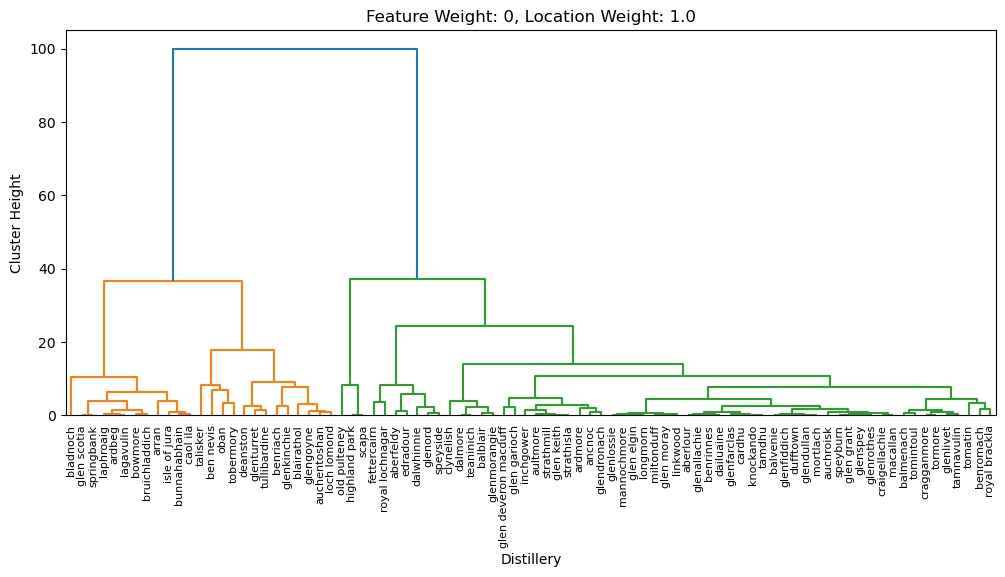

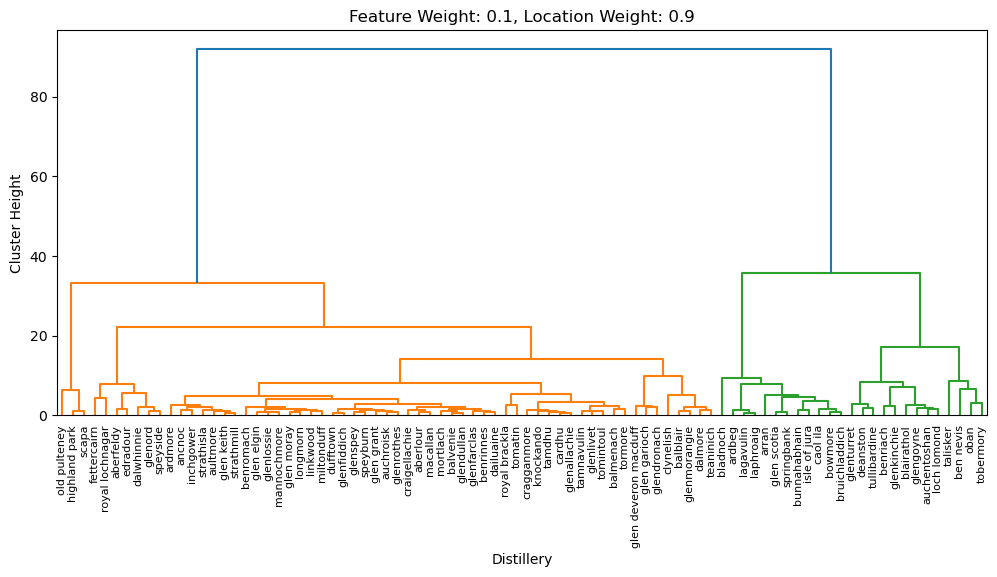

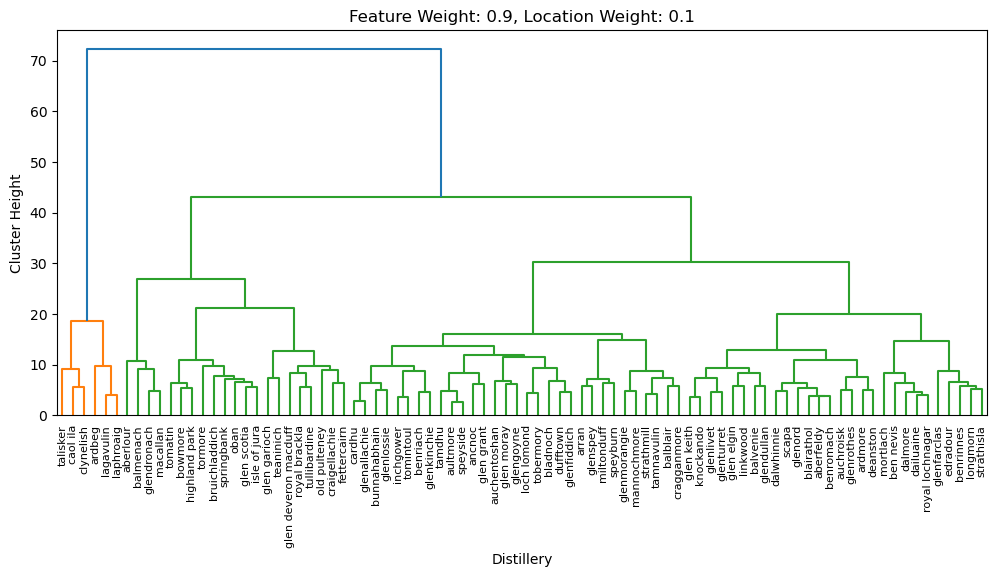

/var/folders/wm/p_fdrppn6vdc156547mypxf00000gn/T/ipykernel_12152/250618343.py:13: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(weighted_average_distances, method='ward')


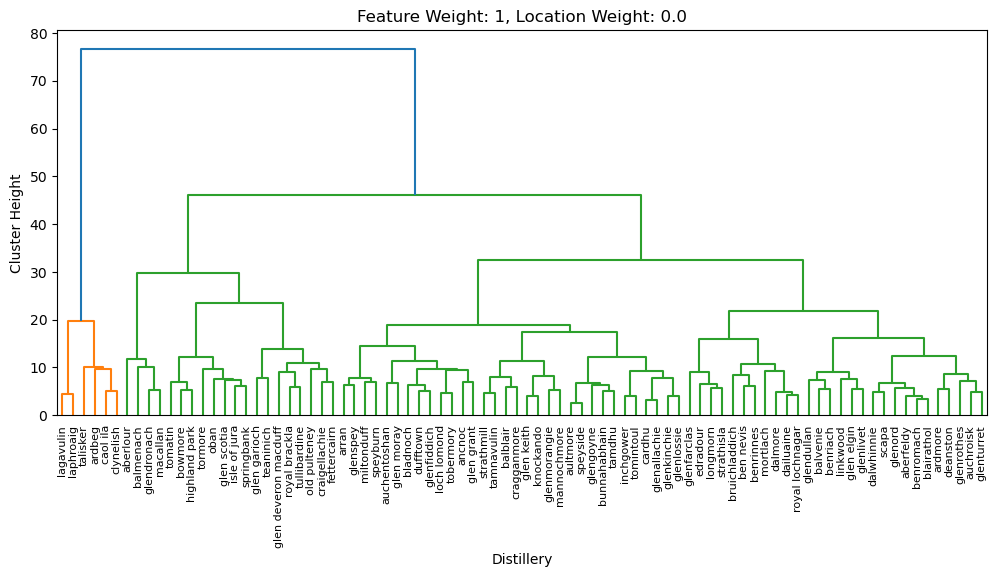

In [159]:
# all location, location + lil features, features + lil location, all features
# plotting to view
weight_range = [0,0.1,0.9,1]
weight_range_reversed = np.flip(weight_range)

# Iterate over the weight combinations
for feature_weights,location_weights in zip(weight_range,weight_range_reversed):
        # Compute the weighted average distance matrix
        weighted_average_distances = (feature_weights * feature_dist +
                                      location_weights * distance_distil)

        # Perform hierarchical clustering using Ward's linkage method
        Z = linkage(weighted_average_distances, method='ward')

        # Visualize the dendrogram
        plt.figure(figsize=(12, 5))
        plt.title(f'Feature Weight: {feature_weights}, Location Weight: {location_weights}')
        dendrogram(Z, labels=scaled_dist_df.index, leaf_rotation=90, leaf_font_size=8)
        plt.xlabel('Distillery')
        plt.ylabel('Cluster Height')
        plt.show()

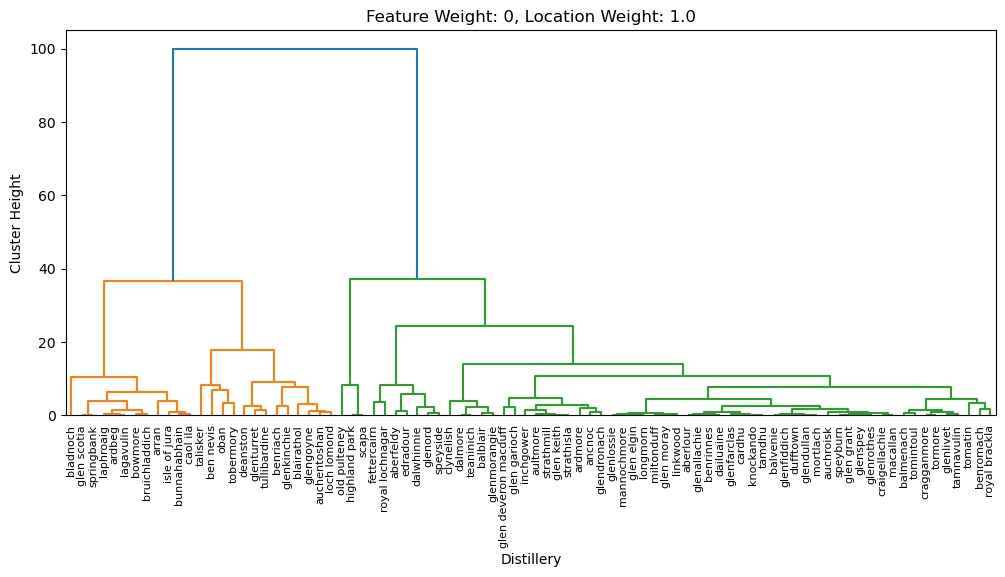

ValueError: Length of values (0) does not match length of index (86)

In [165]:

# Iterate over the weight combinations
# slicing based on previous visual
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'pink', 'gray', 'olive', 'teal', 'magenta']
# setting my cluster count manually - based on previous diagram
height = [20,20,20,25]
i = 0 
for feature_weighted_distances, location_weights in zip(weight_range, weight_range_reversed):
    weighted_average_distances = (feature_weighted_distances * feature_dist +
                                  location_weights * distance_distil.values)

    Z = linkage(weighted_average_distances, method='ward')

    plt.figure(figsize=(12, 5))
    plt.title(f'Feature Weight: {feature_weighted_distances}, Location Weight: {location_weights}')
    dendrogram(Z, labels=scaled_dist_df.index, leaf_rotation=90, leaf_font_size=8)
    plt.xlabel('Distillery')
    plt.ylabel('Cluster Height')
    plt.show()

    import matplotlib.pyplot as plt
    distil_with_clusters[f'Cluster_weighted {i}'] = cluster_labels
    print(f'Cluster labels: {cluster_labels}')
    map_scotland = folium.Map(location=[location.latitude, location.longitude], zoom_start=6)

    for idx, distil_point in distil_with_clusters.iterrows():
        if distil_point['geometry']:
            latitude, longitude = distil_point['geometry'].y, distil_point['geometry'].x
            cluster_label = cluster_labels[idx - 1]  # Adjust for zero-based indexing
            folium.CircleMarker(
                location=[latitude, longitude],
                radius=3,
                alpha = 0.5,
                color=colors[cluster_label-1],  
                popup=distil_point['Distillery'] + f', Cluster: {cluster_label}'
            ).add_to(map_scotland)

    display(map_scotland)
    map_scotland.save(f"map_scotland_clustered_hier_{feature_weighted_distances}_{location_weights}.html")
    i+=1

In [ ]:
# Round 2 - clusters, taking the 3 largest clusters and re-clustering the points
# Setting preferred mix to 0.9(flavours+preference similarity) and 0.1 distances

for feature_weighted_distances, location_weights in zip(weight_range, weight_range_reversed):
    if feature_weighted_distances == 0.9 and location_weights == 0.1:
        # Compute the weighted average distance matrix
        weighted_average_distances = (feature_weighted_distances * feature_dist +
                                    location_weights * distance_distil.values)

        # Perform hierarchical clustering using Ward's linkage method
        Z = linkage(weighted_average_distances, method='ward')

        # Visualize the dendrogram
        plt.figure(figsize=(12, 5))
        plt.title(f'Feature Weight: {feature_weighted_distances}, Location Weight: {location_weights}')
        dendrogram(Z, labels=scaled_dist_df.index, leaf_rotation=90, leaf_font_size=8)
        plt.xlabel('Distillery')
        plt.ylabel('Cluster Height')
        plt.show()

        # Obtain cluster labels from the hierarchical clustering
        cluster_labels = fcluster(Z, 20, criterion='distance')
        distil_with_clusters[f'Cluster_weighted {i}'] = cluster_labels
        print(f'Cluster labels: {cluster_labels}')
        # Identify the 3 largest clusters
        cluster_sizes = pd.Series(cluster_labels).value_counts()
        largest_clusters = cluster_sizes.nlargest(3).index.tolist()
        
        # Combine data points belonging to the largest clusters
        combined_data = np.concatenate([weighted_average_distances[np.where(cluster_labels == cluster_index)[0]] for cluster_index in largest_clusters])
        
        # Perform hierarchical clustering to further split the combined data
        Z_sub = linkage(combined_data, method='ward')
        
        # Obtain cluster labels from the hierarchical clustering
        cluster_labels_sub = fcluster(Z_sub, 6, criterion='maxclust')
        # adding 4 to labels to avoid overlap with previous labels
        cluster_labels_sub += 4
        print(cluster_labels_sub)
        # Update the cluster labels in distil_with_clusters
        current_index = 0
        for cluster_index in largest_clusters:
            cluster_indices = np.where(cluster_labels == cluster_index)[0]
            num_points = len(cluster_indices)
            # updating the cluster labels
            distil_with_clusters.loc[cluster_indices, f'Cluster_weighted 2'] = cluster_labels_sub[current_index:current_index + num_points]
            current_index += num_points

        # Visualize the dendrogram - deeper
        plt.figure(figsize=(12, 5))
        plt.title(f'Feature Weight: {feature_weighted_distances}, Location Weight: {location_weights}')
        dendrogram(Z_sub, leaf_rotation=90, leaf_font_size=8)
        plt.xlabel('Distillery')
        plt.ylabel('Cluster Height')
        plt.show()

        i+=1

In [ ]:
# plot of clusters after 2 rounds of Hierarcical Clustering
map_scotland = folium.Map(location=[location.latitude, location.longitude], zoom_start=6)
num_clusters = len(distil_with_clusters['Cluster_weighted 2'].unique())

map_scotland = folium.Map(location=[location.latitude, location.longitude], zoom_start=6)

for idx, distil_point in distil_with_clusters.iterrows():
    if distil_point['geometry']:
        latitude, longitude = distil_point['geometry'].y, distil_point['geometry'].x  
        folium.CircleMarker(
            location=[latitude, longitude],
            radius=3,  
            color=colors[distil_point['Cluster_weighted 2']],  
            popup=distil_point['Distillery']
        ).add_to(map_scotland)
display(map_scotland)
map_scotland.save("map_scotland_clustered_hier.html")

# I am tempted to run a 3rd round on the 2 largest clusters, but will refrain for now on max cluster number advice 

In [ ]:
distil_with_clusters

In [ ]:
## DBSCAN - All location or all features
# Define the parameter grid for manual search
param_grids = [
    {'eps': 0.8, 'min_samples': 2},  # Adjust the values as needed for version 1
    {'eps': 5, 'min_samples': 3}   # Adjust the values as needed for version 2
]

# Weight combinations
weight_combinations = [
    (0, 1),   # Version 1
    (1, 0)    # Version 2
]

# Colors for plotting
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'teal']

# Iterate over the weight combinations
for version, (feature_weighted_distances, location_weights) in enumerate(weight_combinations, start=1):
    weighted_average_distances = (feature_weighted_distances * feature_dist +
                                  location_weights * distance_distil)

    # Get the parameters for the current version
    param_grid = param_grids[version - 1]

    dbscan = DBSCAN(eps=param_grid['eps'], min_samples=param_grid['min_samples'])
    cluster_labels = dbscan.fit_predict(weighted_average_distances)

    # Compute the silhouette score for comparison
    silhouette = silhouette_score(weighted_average_distances, cluster_labels)
    print(f"Version {version} - Silhouette Score: {silhouette}")


    # Add cluster labels to the dataframe
    distil_with_clusters[f'Cluster_weightedDB {version}'] = cluster_labels

    # Create a folium map centered around Scotland
    map_scotland = folium.Map(location=[location.latitude, location.longitude], zoom_start=6)

    for idx, distil_point in distil_with_clusters.iterrows():
        if distil_point['geometry']:
            latitude, longitude = distil_point['geometry'].y, distil_point['geometry'].x
            cluster_label = cluster_labels[idx]  
            folium.CircleMarker(
                location=[latitude, longitude],
                radius=3,
                color=colors[cluster_label],  
                alpha = 0.5,
                popup=distil_point['Distillery'] + f', Cluster: {cluster_label}'
            ).add_to(map_scotland)

    display(map_scotland)
    map_scotland.save(f"map_scotland_clustered_dbscan_version_{version}.html")

# location only is not amazing, but its not bad, anything super close is in the same cluster, but DBscan doesn't really like the flavour euclidean distances, so I'm stickig with hierarch

In [ ]:
distil_with_clusters

In [ ]:
# K-means just because  - only on features not location

k = 9
data = final_features
kmeans = KMeans(n_clusters=k, random_state=42)

kmeans.fit(flavor_distance)

centroids = kmeans.cluster_centers_

labels = kmeans.labels_
distil_with_clusters['Cluster_k'] = labels
map_scotland = folium.Map(location=[location.latitude, location.longitude], zoom_start=6)

for idx, distil_point in distil_with_clusters.iterrows():

    latitude, longitude = distil_point['geometry'].y, distil_point['geometry'].x
    cluster_label = cluster_labels[idx - 1]  
    folium.CircleMarker(
        location=[latitude, longitude],
        radius=3,
        color=colors[labels[idx]], 
        popup=distil_point['Distillery'] + f', Cluster: {cluster_label}'
    ).add_to(map_scotland)

display(map_scotland)
  

distil_with_clusters['Cluster_k'] = labels

In [ ]:
final_cluster = distil_with_clusters[['Distillery', 'Cluster_weighted 2', 'Body', 'Sweetness', 'Smoky', 'Medicinal', 'Tobacco', 'Honey', 'Spicy', 'Winey', 'Nutty', 'Malty', 'Fruity', 'Floral']]

In [ ]:
final_cluster.rename(columns={'Cluster_weighted 2': 'Cluster'}, inplace=True)

# Final Clusters 

In [ ]:
final_cluster

In [ ]:
# Final Cluster Map - using 2 rounds of hierarchical clustering
map_scotland = folium.Map(location=[location.latitude, location.longitude], zoom_start=6)
num_clusters = len(distil_with_clusters['Cluster_weighted 2'].unique())

map_scotland = folium.Map(location=[location.latitude, location.longitude], zoom_start=6)

for idx, distil_point in distil_with_clusters.iterrows():
    if distil_point['geometry']:
        latitude, longitude = distil_point['geometry'].y, distil_point['geometry'].x  
        folium.CircleMarker(
            location=[latitude, longitude],
            radius=3,  
            color=colors[distil_point['Cluster_weighted 2']],  
            popup=distil_point['Distillery']
        ).add_to(map_scotland)
display(map_scotland)
map_scotland.save("map_scotland_clustered_hier.html")

In [ ]:
# Extract the relevant columns for the heatmap
heatmap_data = distil_with_clusters[['Cluster_weighted 0', 'Cluster_weighted 3']]

# Pivot the data for heatmap visualization
heatmap_matrix = heatmap_data.pivot_table(index='Cluster_weighted 3', columns='Cluster_weighted 0', aggfunc=len, fill_value=0)

# Calculate the sum of values in each row (axis=1) to get the denominator for row-wise ratios
row_sums = heatmap_matrix.sum(axis=1)

# Divide each row by its sum to get row-wise ratios
heatmap_matrix = heatmap_matrix.div(row_sums, axis=0)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_matrix, cmap='coolwarm', annot=True, fmt='.2f', linewidths=.5)
plt.title('Cluster location vs Cluster features')
plt.xlabel('Cluster features')
plt.ylabel('Cluster location')
plt.show()



In [ ]:
box = distil_with_clusters[['Cluster_weighted 0', 'Cluster_weighted 3']]
# Pivot for heatmap visualization
heatmap_matrix = box.pivot_table(index=distil_with_clusters.index, columns=['Cluster_weighted 0', 'Cluster_weighted 3'], aggfunc=len, fill_value=0)

plt.figure(figsize=(12, 20))
sns.heatmap(heatmap_matrix, cmap='coolwarm', annot=True, fmt='d', linewidths=.5)
plt.title('Cluster location vs Cluster flavours and ratings')
plt.xlabel('location, flavours')
plt.ylabel('Distillery')
plt.show()

# Cluster Recommendation

In [ ]:
def distillery_rec(distillery_name):
    if distillery_name == 'Idk what I want':
        print('The Top 3 rated Distilleries are ', top_3.index.values)
        print('The Author\'s favourite Distillery is Balvenie')
        print('Once you\'ve chosen your distillery, just pick a bottle in your price range. \n The older the better, but if you\'re not sure, just go with the 12 year old.')
        print('If you pick a very cheap bottle, you\'ll probably get a blend, which is fine, but they are better mixed with coke.')
        print('If you get a Single Malt, you can drink it neat, or with a little water to open up the flavours.')
        return
    else:
        # Find the cluster of the given distillery name
        cluster = final_cluster[final_cluster['Distillery'] == distillery_name]['Cluster'].values[0]
        
        # Find all distilleries with the same cluster
        distilleries_same_cluster = final_cluster[final_cluster['Cluster'] == cluster]['Distillery'].values
        
        # Print distilleries with the same cluster
        print(f"Distilleries in the same cluster as {distillery_name}:")
        for distillery in distilleries_same_cluster:
            print(distillery)


#distillery_name = 'replace with distillery name'
distillery_rec(distillery_name)

In [ ]:
## or interactively
def distillery_rec():
    distillery_list = " ".join([distillery.lower() for distillery in final_cluster['Distillery']])
    print("Available Distilleries:",distillery_list)

    choice = input("Which Distillery do you want something similar to? (Enter 'Idk what I want' if unsure): ").lower()
    
    if choice == 'idk what i want':
        print('You should try:')
        print('The Top 3 rated Distilleries are', top_3.index.values)
        print('The Author\'s favourite Distillery is Balvenie')
        print('Once you\'ve chosen your distillery, just pick a bottle in your price range.')
        print('The older the better, but if you\'re not sure, just go with the 12 year old.')
        print('If you pick a very cheap bottle, you\'ll probably get a blend, which is fine, but they are better mixed with coke.')
        print('If you get a Single Malt, you can drink it neat, or with a little water to open up the flavours.')
    else:
        # Find the cluster of the given distillery name
        cluster = final_cluster[final_cluster['Distillery'].str.lower() == choice]['Cluster'].values[0]
        
        # Find all distilleries with the same cluster
        distilleries_same_cluster = final_cluster[final_cluster['Cluster'] == cluster]['Distillery'].values
        
        # Print distilleries with the same cluster
        print(f"Distilleries in the same cluster as {choice}:")
        for distillery in distilleries_same_cluster:
            print(distillery)

In [ ]:
distillery_rec()

In [ ]:
final_cluster.to_pickle('final_cluster.pkl')

In [ ]:
final_cluster